In [67]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion
from pyspark.ml.regression import LinearRegression
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# Initialize Spark session
spark = SparkSession.builder.appName("PopulationPrediction").getOrCreate()

# Import necessary libraries
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("PopulationPrediction").getOrCreate()

# Path to the file in Google Drive
file_path = '/content/drive/My Drive/world_population.csv'

# Load dataset
df = spark.read.option("header", "true").option("inferSchema", "true").option("sep", ";").csv(file_path)

# Show the first 5 rows of the DataFrame to see the structure
df.show(5)

# Select specific columns
population_df = df.select('Country/Territory', '2022 Population', '2020 Population',
                          '2015 Population', '2010 Population', '2000 Population')

# Drop rows with missing values
population_df = population_df.dropna()

# Show the first 5 rows of the new DataFrame after dropping missing values
population_df.show(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+----+----+-----------------+----------------+---------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------+-----------------+-----------+---------------------------+
|Rank|CCA3|Country/Territory|         Capital|Continent|2022 Population|2020 Population|2015 Population|2010 Population|2000 Population|1990 Population|1980 Population|1970 Population|Area (km²)|Density (per km²)|Growth Rate|World Population Percentage|
+----+----+-----------------+----------------+---------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------+-----------------+-----------+---------------------------+
|  36| AFG|      Afghanistan|           Kabul|     Asia|       41128771|       38972230|       33753499|     

In [73]:
import sqlite3
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("PopulationPrediction").getOrCreate()

# Assuming df is already loaded with the necessary data
population_columns = ["1970 Population", "1980 Population", "1990 Population",
                     "2000 Population", "2010 Population", "2015 Population",
                     "2020 Population", "2022 Population"]

# Melting the dataframe into long format
df_melted = df.selectExpr("`Country/Territory` as Country",
                         "stack(8, '1970', `1970 Population`, '1980', `1980 Population`, "
                         "'1990', `1990 Population`, '2000', `2000 Population`, "
                         "'2010', `2010 Population`, '2015', `2015 Population`, "
                         "'2020', `2020 Population`, '2022', `2022 Population`) as (Year, Population)")

# Cast columns to appropriate types
df_melted = df_melted.withColumn("Year", col("Year").cast("int")).withColumn("Population", col("Population").cast("double"))

# Filter data for Afghanistan
countryname_df = df_melted.filter(df_melted.Country == "Afghanistan")

# Store data in SQLite
countryname_pandas = countryname_df.toPandas()
conn = sqlite3.connect("population.db")
countryname_pandas.to_sql("population", conn, if_exists="replace", index=False)

# Feature engineering: VectorAssembler
assembler = VectorAssembler(inputCols=["Year"], outputCol="features")
countryname_features = assembler.transform(countryname_df).select("Year", "features", "Population")

# Polynomial features expansion
polyExpansion = PolynomialExpansion(degree=2, inputCol="features", outputCol="polyFeatures")
countryname_poly = polyExpansion.transform(countryname_features)

# Train a linear regression model
lr = LinearRegression(featuresCol="polyFeatures", labelCol="Population")
model = lr.fit(countryname_poly)

# Make predictions for historical data (for visualization)
historical_predictions = model.transform(countryname_poly).toPandas()

# Predict future years (2030 & 2050)
future_years = spark.createDataFrame([(2030,), (2050,)], ["Year"])

# Apply the same transformation to future years
future_years = assembler.transform(future_years)
future_poly = polyExpansion.transform(future_years)

# Generate predictions for future years
predictions = model.transform(future_poly).toPandas()

# Format predictions
predictions['prediction'] = predictions['prediction'].apply(lambda x: f'{int(round(x)):,}')

print("Afghanistan Population Predictions:")
print(predictions[['Year', 'prediction']])


Afghanistan Population Predictions:
   Year  prediction
0  2030  53,726,937
1  2050  91,872,585


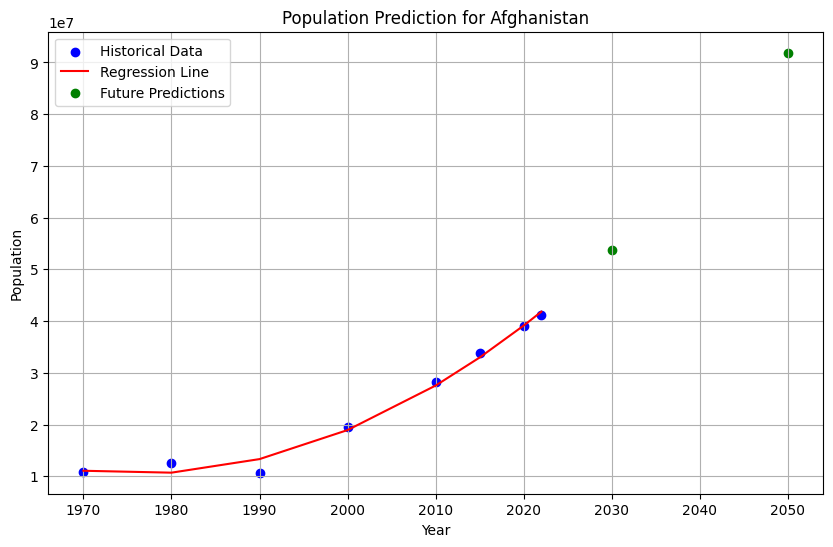


2020 Population from SQLite:
[('Afghanistan', 2020, 38972230.0)]


In [74]:
# Visualization
plt.figure(figsize=(10, 6))

# Historical Data
plt.scatter(countryname_pandas["Year"], countryname_pandas["Population"],
            color='blue', label='Historical Data')
# Regression Line (using model's predictions on historical data)
plt.plot(historical_predictions["Year"], historical_predictions["prediction"],
         color='red', label='Regression Line')

# Future Predictions
plt.scatter(predictions["Year"], predictions["prediction"].str.replace(',', '').astype(float),
            color='green', label='Future Predictions')

plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Population Prediction for Afghanistan')
plt.legend()
plt.grid(True)
plt.show()
# SQL Query Example
import sqlite3

# Try opening a connection if it's closed
try:
    # If conn is not open, trying to use it will throw an error, so we reconnect here
    cursor = conn.cursor()
except sqlite3.ProgrammingError:
    # Reconnect if the connection was closed
    conn = sqlite3.connect('population.db')  # Replace with your actual database file path
    cursor = conn.cursor()

# Execute the query for the 2020 population
cursor.execute("SELECT * FROM population WHERE Year = 2020")

print("\n2020 Population from SQLite:")
print(cursor.fetchall())

# Close the cursor and connection after usage
cursor.close()
conn.close()

